# Optilisation avec numpyro

- Author : Jean Eric Campagne
- SDC update : 2023/10/01
- affiliation : IJCLab/IN2P3/CNRS
- CC: kernel conda_jax0235_py310
- creation date : 2023-10-03
- update : 2023-11-11


| computer | processor | kernel              |    date     |
| --- | --- | --- | --- |
| CC       | CPU       | conda_jax0325_py310 | 2023-11-10  |
| macbookpro | CPU | conda_jaxcpu_dsps_py310 | 2023-11-10  | 


libraries 
---------

jax
~~~


- jaxlib-0.3.25+cuda11.cudnn82
- jaxopt
- optax
- corner
- arviz
- numpyro



In [1]:
import numpy as np


import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
jax.config.update("jax_enable_x64", True)

import numpyro
from numpyro import optim
from numpyro.diagnostics import print_summary
import numpyro.distributions as dist
from numpyro.distributions import constraints
from numpyro.infer import MCMC, HMC, NUTS, SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoBNAFNormal, AutoMultivariateNormal
from numpyro.infer.reparam import NeuTraReparam
from numpyro.handlers import seed, trace, condition

import matplotlib as mpl
from matplotlib import pyplot as plt

import corner
import arviz as az
mpl.rcParams['font.size'] = 20

# Thème: se servir de la librairie [`Numpyro`]([https://num.pyro.ai/en/latest/index.html) 
Bayesian Forward modeling & inference 

On se sert du use-case du notebook `JAX-Optim-regression`.

(Numpyro est la version JAX de Pyro écrit quant à lui en PyTorch). 


Probabilist modeling souvent employé Bayesian modeling. Si on a des observations $Data=(x_i,y_i)$, on peut tenter de les modéliser (*programme de R. A. Fisher en 192 tjrs d'actualité*) par une distribution paramétrée de paramètres $\theta$ (ie. $p(Data,\theta)$). Souvent on merge les paramètres $\theta$ et des variables latentes (cachées) dans un lot des paramètres. Ainsi
$$
\Large
p(Data,\theta) = p(Data|\theta)p(\theta)
$$
$p(\theta)$ est **le prior**, $p(Data|\theta)$ **le likelihood**.

On utilise le théorème de Bayes et l'inférence pour exprimer la distribution posterior sur les variables cachées $z$ et en tirer des conclusions
$$
\Large
p(\theta|Data) = \frac{p(Data,\theta)}{p(Data)} = \frac{p(Data|\theta)p(\theta)}{p(Data)}
$$
et $p(Data)$ est l'**evidence**/*la vraisemblance* du modèle (c'est-à-dire la probabilité que le modèle rende compte des observations). D'où la recherche de maximum de vraisemblance. Notez que
$$
\Large
p(Data) = \int d\theta\ p(Data,\theta)
$$
l'évidence est la **marginal likelihood** sur les paramètres. La détermination des paramètres $\theta$ (en séparant des varaibles latentes) se fait en maximisant 
$$
\Large
\hat{\theta} = argmax_\theta \mathbb{E}_{(x,y)\sim Data}[ \log p(Data,\theta) ]
$$

Examples d'observations ($x_i,y_i$) iid avec un modèle $f(x_i; z)$ et un prior/likehood gaussien
$$
\Large
\begin{align}
p(\theta|\{x_i,y_i\}_{i<N}) &\propto \prod_{i=1}^N e^{-\frac{1}{2\sigma^2}(y_i - f(x_i; \theta))^2}  \times e^{-\frac{1}{2}\theta^T \Sigma_p^{-1} \theta} \\
& \propto e^{-\frac{1}{2}(\theta - \hat{\theta})^T \hat{\Sigma}^{-1}_\theta (\theta - \hat{\theta})}
\end{align}
$$
(nb. les priors sont les équivalents des régularisations dans les pbs non probabilistes).
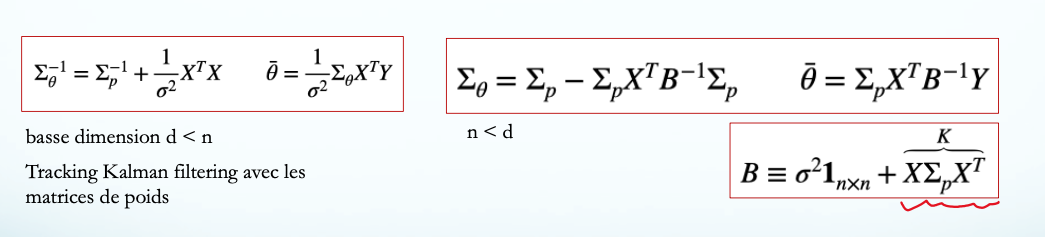

La pdf d'une prédiction (**posterior predictive distribution**) se calcule selon:
$$
\Large
p(y_{new}|x_{new}, Data) = \int d\theta \ p(y_{new}|x_{new},Data,\theta) p(\theta|Data)
$$
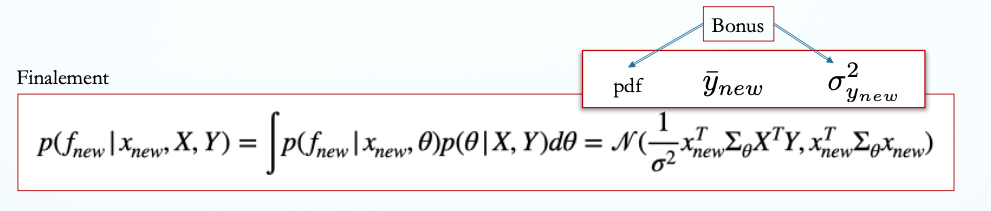

In [2]:
def plot_params_kde(samples,hdi_probs=[0.393, 0.865, 0.989], 
                    patName=None, fname=None, pcut=None,
                   var_names=None, point_estimate="median"):
    
    if pcut is not None:
        low = pcut[0]
        up  = pcut[1] 
        #keep only data in the [low, up] percentiles ex. 0.5, 99.5
        samples={name:value[(value>np.percentile(value,low)) &  (value<np.percentile(value,up))] \
          for name, value in samples.items()}
        len_min = np.min([len(value) for name, value in samples.items()])
        len_max = np.max([len(value) for name, value in samples.items()])
        if (len_max-len_min)>0.01*len_max:
            print(f"Warning: pcut leads to min/max spls size = {len_min}/{len_max}")
        samples = {name:value[:len_min] for name, value in samples.items()}
    
    axs= az.plot_pair(
            samples,
            var_names=var_names,
            figsize=(10,10),
            kind="kde",
    #        marginal_kwargs={"plot_kwargs": {"lw": 3, "c": "b"}},
            kde_kwargs={
#                "hdi_probs": [0.68, 0.9],  # Plot 68% and 90% HDI contours
                "hdi_probs":hdi_probs,  # 1, 2 and 3 sigma contours
                "contour_kwargs":{"colors":('r', 'green', 'blue'), "linewidths":3},
                "contourf_kwargs":{"alpha":0},
            },
            point_estimate_kwargs={"lw": 3, "c": "b"},
            marginals=True, textsize=20, point_estimate=point_estimate,
        );
    
    plt.tight_layout()
    
    if patName is not None:
        patName_patch = mpatches.Patch(color='b', label=patName)
        axs[0,0].legend(handles=[patName_patch], fontsize=40, bbox_to_anchor=(1, 0.7));
    if fname is not None:
        plt.savefig(fname)
        plt.close()

In [3]:
def mean_fn(x, params):
    """Parametrisation avant et apres (t=0) """
    R0 = params["R0"]
    v  = params["v"]
    k  = params["k"]
    tau =  params["tau"]
    return jnp.where(x < 0, R0 + v*x, R0 + v*x - k*(1.-jnp.exp(-x/tau)))

### au passage vous noterez une autre façon de coder cette fonction (au lieu de `piecewise`)

# Génération d'un dataset (méthode 1) 
Méthode utilisée dans `JAX-Otim-regression`

In [4]:
rng_key = jax.random.PRNGKey(42)
rng_key, rng_key0, rng_key1, rng_key2 = jax.random.split(rng_key, 4)

In [5]:
tMes = jax.random.uniform(rng_key0,minval=-5.,maxval=5.0,shape=(20,))
tMes=jnp.append(tMes,0.0)
tMes=jnp.sort(tMes)

In [6]:
par_true={"R0":35.0, "v":2.20, "k":15.5, "tau": 1.0}
sigma_obs=1.0

In [7]:
RMes = mean_fn(tMes,par_true) + sigma_obs * jax.random.normal(rng_key1,shape=tMes.shape)

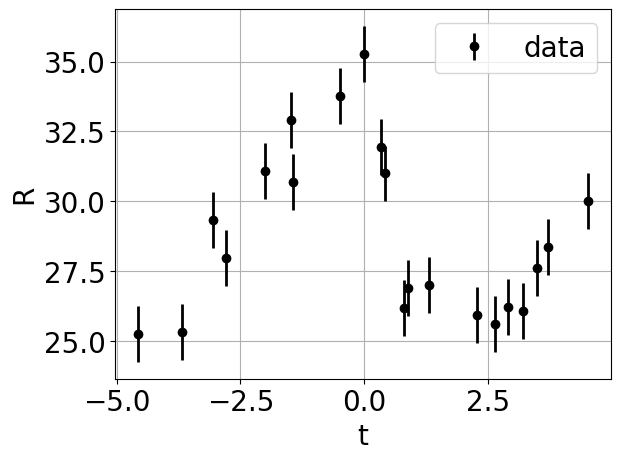

In [8]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

# Bayesian modeling

In [9]:
def model(t,Robs=None,
          R0_min=10.,v_min = 0.5,k_min = 1., tau_min=0.1,
          R0_max=50.,v_max = 3.5,k_max = 10., tau_max=5.0,
          sigma= 1.0):
    
    # priors
    R0 = numpyro.sample("R0", dist.Uniform(R0_min,R0_max))
    v  = numpyro.sample("v", dist.Uniform(v_min,v_max))
    k  = numpyro.sample("k", dist.Uniform(k_min,k_max))
    tau= numpyro.sample("tau", dist.Uniform(tau_min,tau_max))

    
    params = {"R0":R0, "v":v, "k":k, "tau":tau}
    mu = mean_fn(t,params)
    
    with numpyro.plate("obs", t.shape[0]):  # les observables sont indépendantes
        numpyro.sample('R', dist.Normal(mu, sigma), obs=Robs)


## Diagramatic representation

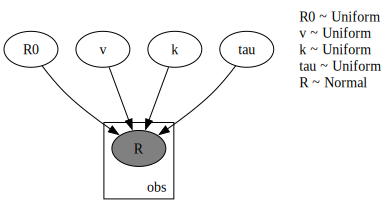

In [10]:
numpyro.render_model(model, model_args=(jnp.array([0.]),jnp.array([1.])),render_distributions=True)

Pour approfondir la notation diagramatique voir [ici](https://en.wikipedia.org/wiki/Plate_notation). La notion de `plate` (*) n'est pas indispensabe pour le modèle simple que nous avons à traiter ici.

(*: je ne pense pas qu'`assiette` soit la bonne traduction dans ce contexte).

# Génération d'un dataset (méthode 2) 

Foward modeling en conditionnant les paramètres à des valeurs fixes. Mais on peut également ne pas contionner le model et utiliser la générations des paramètres via les priors

In [11]:
from numpyro.handlers import seed, trace, condition
# So, let's generate the data at the fiducial parameters
fiducial_model = condition(model, par_true)
# Run the conditionned model (if not conditionned the priors are executed)
trace_data = trace(seed(fiducial_model, jax.random.PRNGKey(42))).get_trace(tMes, sigma=sigma_obs)

In [12]:
trace_data

OrderedDict([('R0',
              {'type': 'sample',
               'name': 'R0',
               'fn': <numpyro.distributions.continuous.Uniform at 0x106142d70>,
               'args': (),
               'kwargs': {'rng_key': None, 'sample_shape': ()},
               'value': 35.0,
               'scale': None,
               'is_observed': True,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('v',
              {'type': 'sample',
               'name': 'v',
               'fn': <numpyro.distributions.continuous.Uniform at 0x15b832f80>,
               'args': (),
               'kwargs': {'rng_key': None, 'sample_shape': ()},
               'value': 2.2,
               'scale': None,
               'is_observed': True,
               'intermediates': [],
               'cond_indep_stack': [],
               'infer': {}}),
             ('k',
              {'type': 'sample',
               'name': 'k',
               

In [13]:
RMes_bis = trace_data['R']["value"]

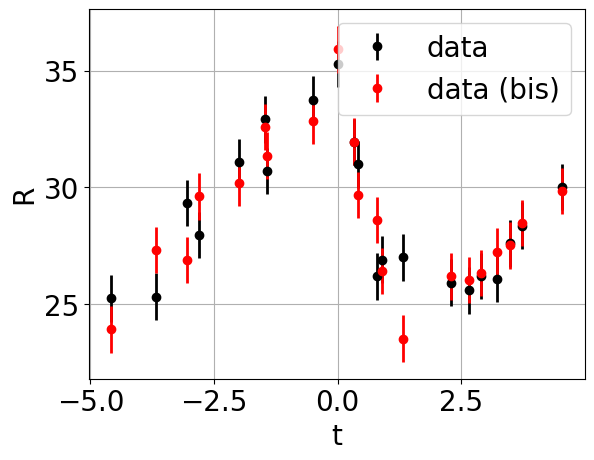

In [14]:
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.errorbar(tMes,RMes_bis,yerr=sigma_obs, fmt='o', linewidth=2, capsize=0, c='r', label="data (bis)")
plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

# Inférence bayesienne à l'aide de génération de chaine Monte Carlo en utilisant une version améliorée du Hamiltonian Monte Carlo (NUTS).

HMC en 180sec:
$$
\Large
p_c(x) = \frac{e^{-V(x)}}{Z} \Leftrightarrow -\log(p_c(x)) = V(x) + Cte
$$
où 
$$
\Large
V(x) = -\log(\pi(x)\mathcal{L}(x|\mathcal{D}))
$$
avec $\pi(x)$ le *prior* et $\mathcal{L}$ le likelihood. La technique HMC introduit une variable conjuguée à $x$, que l'on note opportunément $p$ et l'on forme la fonction (hamiltonien) 
$$
\Large
H(x,p) = V(x) + E_c(p)
$$
avec $E_c(p)$ une pseudo-énergie cinétique (terme quadratique avec matrice de masse).
$$
\Large
\dot{x} = \frac{\partial H}{\partial p} = \frac{\partial E_c}{\partial p} = p
\qquad 
\dot{p} = -\frac{\partial H}{\partial x} = -\frac{\partial V}{\partial x} = \frac{\partial \log p_c(x)}{\partial x} 
$$

Algo:
- tirage aléatoire de $p_i\sim \mathcal{N}(0,1)$; puis l'on initialise $p_{new}=p_i$ et symétriquement $x_{new}=x_i$; 
- itération de $n_{steps}$ étapes d'intégration des équations du mouvement suivant la méthode dite de l'algorithme **leapfrog** en anglais ou **saute-mouton** en français (traduction non-littérale): 
$$
\Large
\begin{cases}
	p_{new} &= p_{new} - \varepsilon \times \frac{1}{2} \frac{\partial V(x)}{\partial x}|_{x=x_{new}}  \\
	x_{new} &= x_{new} + \varepsilon \times p_{new} \\
	p_{new} &= p_{new} - \varepsilon \times \frac{1}{2} \frac{\partial V(x)}{\partial x}|_{x=x_{new}}
	\end{cases}
$$
(notons la mise à jour du gradient en cours de route);
- puis, on renverse le moment $p_{new} = -p_{new}$;
- enfin, on procède comme pour l'algorithme de Metropolis selon la probabilité d'acceptation du nouvel état  $(x_{new},p_{new})$:
$$
\Large
p_{acc} = \mathrm{min}\left\{1,r=\frac{\tilde{P}(x_{new},p_{new})}{\tilde{P}(x_i,p_i)} \right\}
$$
avec
$$
\Large
\tilde{P}(x,y) = e^{-H(x,p)} = e^{-V(x)}\times e^{-E_c(p)}
$$
Cela se fait par tirage uniforme d'un nombre $u$ dans l'intervalle $[0,1]$. Si $u<r$ on accepte $x_{new}$ comme valeur pour $x_{i+1}$, sinon on prend $x_i$. Remarquons le découplage qu'il y a entre les deux variables $x$ et $p$. Notons aussi, que l'on ne garde pas $p_{new}$ par la suite.

**NUTS** est une évolution pour aider à déterminer le nombre de steps et la longueur du step pour l'algorithme d'intégration leapfrog.

In [15]:
# Run NUTS.
kernel = NUTS(model, dense_mass=True, target_accept_prob=0.9,
              init_strategy=numpyro.infer.init_to_median())
num_samples = 5_000
n_chains = 4
mcmc = MCMC(kernel, num_warmup=1_000, num_samples=num_samples,  
            num_chains=n_chains,
            chain_method='vectorized',
            progress_bar=False)
mcmc.run(rng_key, t=tMes, Robs=RMes,sigma=sigma_obs, k_max = 20.)
mcmc.print_summary()
samples_nuts = mcmc.get_samples()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
        R0     35.31      0.54     35.31     34.40     36.18   7038.93      1.00
         k     16.56      1.32     16.56     14.35     18.73   5474.07      1.00
       tau      0.95      0.11      0.95      0.77      1.13  10922.05      1.00
         v      2.36      0.21      2.36      2.02      2.72   6432.35      1.00

Number of divergences: 0


## Si vous voulez observer La barre de progression avec `chain_method='vectorized'` elle ne donnera qu'une seule chaine peut être mais c'est bien 4 qui seront générées. Cette barre de progression dans certains cas ralentit beaucoup la génération. Vous pouvez opter pour `chain_method='sequential’`, tandis que `parallel` nécessite tout comme `pmap` un nombre de devices identique au nombre de chaines.

## Vous pouvez jouer sur num_warmup, num_samples, n_chains pour voir comment évoluent la qualité du sampling...


##  Il faut regarder: **r_hat** qui doit être 1, ensuite **Number of divergences** qui si non nul indique que la génération a été coupée à cause de problème (ex. frontière, proba squeezed...), et ensuite **n_eff** qui si on le divise par $4\times 5,000$  donne une efficacité de génération. Il y a une autre façon (standard) de calculer cette efficacité via `arviz.ess`. Cette efficacité est reliée à la longueur d'auto-corrélation de la chaine Markov, ou dit autrement à l'indépendance des échantillons.

In [16]:
az.ess(samples_nuts, relative=True)  # efficacité relative

<xarray.Dataset>
Dimensions:  ()
Data variables:
    R0       float64 0.3472
    k        float64 0.2586
    tau      float64 0.563
    v        float64 0.3152

## noter que l'efficacite est >= 25% ce qui est tres bien. Un simple MCMC atteint en général 0.1% pour par dire moins et on a alors recourt primo à une génération de beaucoup de samples, et ensuite on procède à un sous-échantillonnage (`thinning`) ce qui est très problématique d'un point de vue statistique car on a aucune garantie de produire un lot iid.

/Users/dagoret/anaconda3/envs/conda_py310/lib/python3.10/site-packages/arviz/plots/backends/matplotlib/kdeplot.py:166: UserWarning: The following kwargs were not used by contour: 'linewidth'
  qcs = ax.contour(x_x, y_y, density, **contour_kwargs)


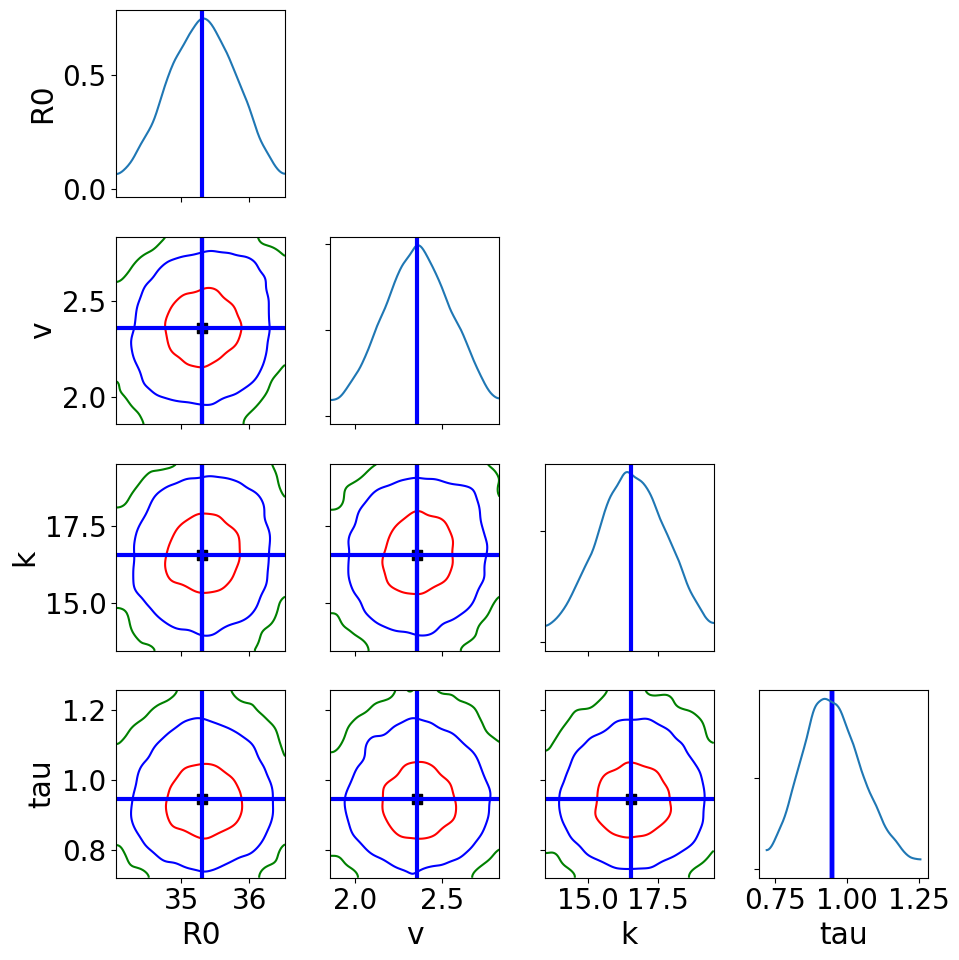

In [17]:
plot_params_kde(samples_nuts, pcut=[1,99], var_names=['R0', 'v','k', 'tau'])

# Prédiction: moyenne, bandes d'erreur...

In [18]:
t_val = np.linspace(-5,5,100)

In [19]:
Rtrue_val = mean_fn(t_val,par_true)

In [20]:
func = jax.vmap(lambda x: mean_fn(t_val,x))

In [21]:
Rall_val= func(samples_nuts)     # on utlise les échantllons de paramétres (R0,v,k,tau)

In [22]:
Rmean_val = jnp.mean(Rall_val,axis=0)

In [23]:
std_R_val = jnp.std(Rall_val,axis=0)

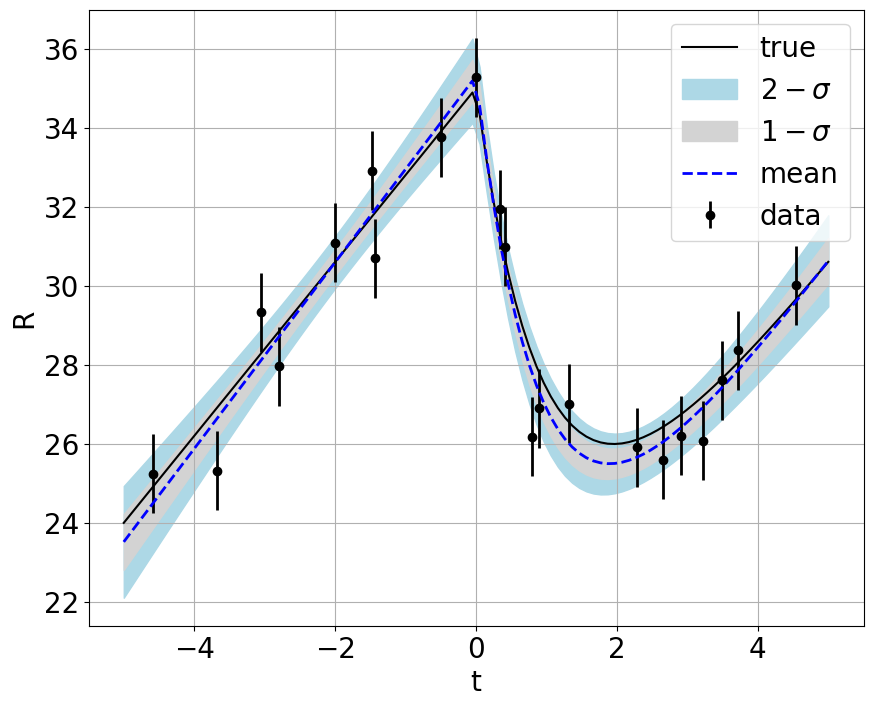

In [24]:
fig=plt.figure(figsize=(10,8))
plt.errorbar(tMes,RMes,yerr=sigma_obs,fmt='o', linewidth=2, capsize=0, c='k', label="data")
plt.plot(t_val,Rtrue_val,c='k',label="true")

plt.fill_between(t_val, Rmean_val-2*std_R_val, Rmean_val+2*std_R_val, 
                    color="lightblue",label=r"$2-\sigma$")
plt.fill_between(t_val, Rmean_val-std_R_val, Rmean_val+std_R_val, 
                    color="lightgray",label=r"$1-\sigma$")
# plot mean prediction
plt.plot(t_val, Rmean_val, "blue", ls="--", lw=2.0, label="mean")


plt.xlabel("t")
plt.ylabel("R")
plt.legend()
plt.grid();

## Exsercices:
- Comparer avec le résultat obtenu dans le nb `JAX-Optim-regression` et produiser l'histogramme sur le `tmin`
- Reprendre l'exercice de génération du dataset sans conditionner par des paramètres fixés mais laisser libre la génération par les priors:

```python
trace_data = trace(seed(model, jax.random.PRNGKey(42))).get_trace(tMes, sigma=sigma_obs)
```
en extraire les paramètres (R0,v,k,tau) générés et poursuivre jusqu'à la dernière figure de comparaison (truth/prediction).
- Dans le modèle nous avons utilisé des priors `Uniform` mais on peut se demander si c'est un choix qui ne conditionne pas trop le résultat. En jetant un oeil [à la doc](https://num.pyro.ai/en/latest/distributions.html?highlight=Uniform#continuous-distributions) je vous propsoe que vous changiez en la distribution en `LogNormal`, `HalfCauchy`, `InverseGamma`.  Vous pouvez vous partager l'exo...

# Takeaway message:
- Vous avez appris à coder un `modèle bayésien` avec Numpyro qui met en jeu les priors et le likelihood.
- Une nouvelle méthode s'offre à vous (`forward modeling`) pour générer des datasets à partir de ce model.
- La génération de chaine de Markov via `NUTS` est simple à coder et expertiser.  
- Notons qu'outre Pyro a sa version JAX (ie. Numpyro), PyMC3 est plus rapide avec JAX [lire ici](https://docs.pymc.io/en/v3/pymc-examples/examples/samplers/GLM-hierarchical-jax.html)